In [ ]:
import pathlib
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
NAMES_FILE = "names.txt"
TERM_TOK = "."
TORCH_SEED = 2147483647
SEED = 42
CONTEXT_SIZE = 3
EMBEDDING_SIZE = 10
W1_NUM_NEURONS = 200
BATCH_SIZE = 64
NUM_EPOCHS_DEV = 1000
NUM_EPOCHS_TRAIN = 200000
LR_DECAY_THRESHOLD = 100000
assert LR_DECAY_THRESHOLD < NUM_EPOCHS_TRAIN
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1
assert TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT == 1.0

random.seed(SEED)
torch.manual_seed(TORCH_SEED)
# device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"
device = torch.device("cpu")
device

device(type='cpu')

In [ ]:
words = [line.strip() for line in pathlib.Path(NAMES_FILE).open("r").readlines()]
random.shuffle(words)
chars = [TERM_TOK] + sorted(list(set("".join(words))))
vocab_size = len(chars)
stoi = {s: i for i, s in enumerate(chars)}
itos = chars

In [ ]:
# build the dataset
def build_dataset(words: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
    X, Y = [], []
    for w in words:
        context = [0] * CONTEXT_SIZE
        for ch in w + TERM_TOK:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


n1 = int(TRAIN_SPLIT * len(words))
n2 = int((TRAIN_SPLIT + VAL_SPLIT) * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
Xtr, Ytr = Xtr.to(device), Ytr.to(device)
Xdev, Ydev = Xdev.to(device), Ydev.to(device)
Xte, Yte = Xte.to(device), Yte.to(device)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# model parameters
C = torch.randn((vocab_size, EMBEDDING_SIZE), device=device)
W1 = torch.randn((CONTEXT_SIZE * EMBEDDING_SIZE, W1_NUM_NEURONS), device=device)
b1 = torch.randn(W1_NUM_NEURONS, device=device)
W2 = torch.randn((W1_NUM_NEURONS, vocab_size), device=device)
b2 = torch.randn(vocab_size, device=device)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad_(True)


def forward(X: torch.Tensor) -> torch.Tensor:
    emb = C[X]
    batch_size = len(emb)
    # (batch_size, CONTEXT_SIZE, EMBEDDING_SIZE) EMBEDDING_SIZE embedding dim per character, CONTEXT_SIZE characters per context, batch_size contexts
    # concat context embeddings since 1st hidden layer expect CONTEXT_SIZE * EMBEDDING_SIZE-length input
    # hidden layer 1
    h = (emb.view(batch_size, CONTEXT_SIZE * EMBEDDING_SIZE) @ W1 + b1).tanh()  # (batch_size, W1_NUM_NEURONS)
    logits = h @ W2 + b2
    return logits


def evaluate(X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
    logits = forward(X)
    loss = F.cross_entropy(logits, target=Y)
    # OR
    # counts = logits.exp()
    # probs = counts / counts.sum(dim=1, keepdim=True)
    # loss = probs[torch.arange(batch_size), Y[idx]].log().mean().neg()
    # intuition: prefer pytorch built-in cross entropy for its numerical statibility and efficiency (use fused kernels and reuse intermediate computations, resulting in more efficient forward and backward passes)
    # also avoids oveerflowing when logits are large and exponentiating them to get counts overflows with log-sum-exp trick
    return loss


print(f"num of parameters in total: {sum(p.numel() for p in parameters)}")

num of parameters in total: 11897


In [ ]:
# exponentially spaced out learning rate search
lre = torch.linspace(start=-3, end=0, steps=1000)
lrs = 10**lre

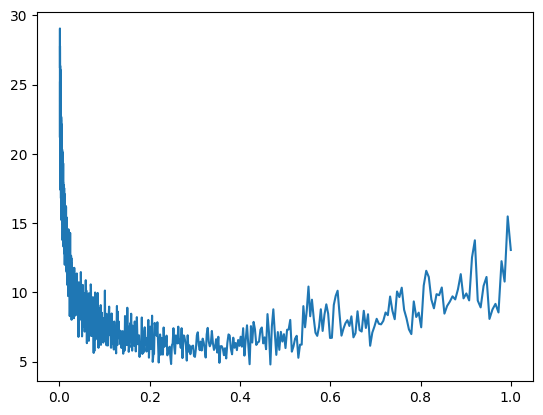

In [ ]:
# learning rate search with dynamic sweep
lri = []
lossi = []

for i in range(NUM_EPOCHS_DEV):
    # minibatch construct
    idx = torch.randint(low=0, high=len(Xtr), size=(BATCH_SIZE,))
    # forward pass and calculate loss
    loss = evaluate(Xtr[idx], Ytr[idx])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track state
    lri.append(lr.item())
    lossi.append(loss.item())

# good learning rate is somewhere around 0.1 as larger learning rates are unstable
plt.plot(lri, lossi)

In [ ]:
# reinitialize model after LR sweep
# init'ing with rand() uniform dist gives
# initial train loss: 11.834287643432617
# initial dev loss: 11.845654487609863
# initial test loss: 11.798942565917969
# compared to randn() normal dist gives
# initial train loss: 25.015134811401367
# initial dev loss: 25.02562141418457
# initial test loss: 24.946767807006836
C = torch.randn((vocab_size, EMBEDDING_SIZE), device=device)
W1 = torch.randn((CONTEXT_SIZE * EMBEDDING_SIZE, W1_NUM_NEURONS), device=device)
b1 = torch.randn(W1_NUM_NEURONS, device=device)
W2 = torch.randn((W1_NUM_NEURONS, vocab_size), device=device)
b2 = torch.randn(vocab_size, device=device)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad_(True)


def forward(X: torch.Tensor) -> torch.Tensor:
    emb = C[X]
    batch_size = len(emb)
    h = (emb.view(batch_size, CONTEXT_SIZE * EMBEDDING_SIZE) @ W1 + b1).tanh()
    logits = h @ W2 + b2
    return logits


def evaluate(X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
    logits = forward(X)
    loss = F.cross_entropy(logits, target=Y)
    return loss

In [ ]:
with torch.no_grad():
    print("initial train loss:", evaluate(Xtr, Ytr).item())
    print("initial dev loss:", evaluate(Xdev, Ydev).item())
    print("initial test loss:", evaluate(Xte, Yte).item())

initial train loss: 25.015134811401367
initial dev loss: 25.02562141418457
initial test loss: 24.946767807006836


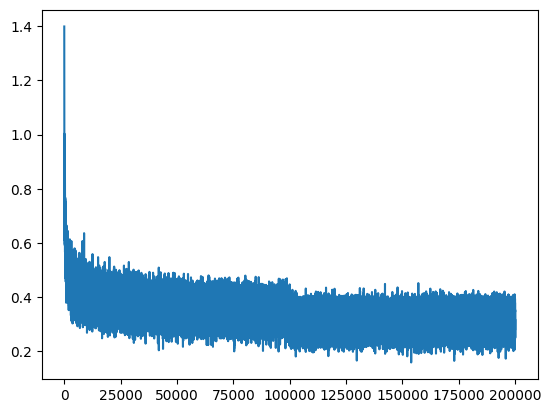

In [ ]:
# train
lossi = []
stepi = []
best_lr = 0.25

for i in range(NUM_EPOCHS_TRAIN):
    # minibatch construct
    idx = torch.randint(low=0, high=len(Xtr), size=(BATCH_SIZE,))
    # forward pass and calculate loss
    loss = evaluate(Xtr[idx], Ytr[idx])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = best_lr if i < LR_DECAY_THRESHOLD else best_lr * 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

plt.plot(stepi, lossi)

In [ ]:
# validate on dev and test sets
with torch.no_grad():
    print(f"loss dev set: {evaluate(Xdev, Ydev).item()}")
    print(f"loss test set: {evaluate(Xte, Yte).item()}")

loss dev set: 2.126028060913086
loss test set: 2.1234521865844727


In [ ]:
# see how vowels cluster, g, q, and '.' are far away (special chars) and others just cluster up? the model is learning structures and representations in the embedding space
if False:
    plt.figure(figsize=(8, 8))
    plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
    for i in range(C.shape[0]):
        plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
    plt.grid("minor")

![Embeddings space visualization](./bigram_embeddings.png)


In [ ]:
# sample
for _ in range(20):
    context = [0] * CONTEXT_SIZE
    out = ""
    while True:
        logits = forward(torch.tensor([context]))
        probs = logits.softmax(dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out += itos[ix]
        if ix == 0:
            break
    print(out)

kysirian.
ira.
amaiana.
nalynn.
feliz.
komie.
nasan.
samarik.
jeniti.
maylee.
itt.
ree.
moenasii.
safan.
lyre.
edy.
tomus.
aedlynn.
tiigh.
nikalse.
